## Try SQLite

TODO: 
1) ~~create four tables in the order of dependencies. (maybe leave the `randman` alone since it is not strictly part of landscape analysis?)~~
2) amend all the pipeline utilties

In [1]:
import sqlite3, pandas as pd
def df_to_sql():
    con = sqlite3.connect('data/First-experiment/landscape-analysis.db')
    df = pd.read_csv('data/First-experiment/loss-surfaces.csv')
    df.to_sql("loss_surfaces", con, if_exists='append', index=False)
    
    con.close()
# df_to_sql()

## Prepare Data
### Generate randman

In [2]:
from src.RandmanFunctions import RandmanConfig, generate_and_save_randman

data_configs = [{'nb_classes': 2, 'nb_units': 3, 'alpha': 3, 'dim_manifold': 1},
                {'nb_classes': 5, 'nb_units': 3, 'alpha': 3, 'dim_manifold': 1},
                {'nb_classes': 2, 'nb_units': 10, 'alpha': 3, 'dim_manifold': 1},
                {'nb_classes': 2, 'nb_units': 3, 'alpha': 1, 'dim_manifold': 1},
                {'nb_classes': 2, 'nb_units': 3, 'alpha': 3, 'dim_manifold': 2}]

In [3]:
# for data_config in data_configs:
#     generate_and_save_randman(RandmanConfig(**data_config))

### Generate problem

In [4]:
# from src.LandscapeAnalysis import generate_randman_problem
# for data_config in data_configs:
#     generate_randman_problem(RandmanConfig(**data_config), nb_hidden=50, loss_fn='cross_entropy')

### Generate samples and match with problems

Here I need the results from surrogate gradient descent to set the boundaries for sampling.

In [5]:
# import sqlite3
# from math import ceil, log2

# # Connect to the SQLite database
# db_path = "data/landscape-analysis.db"
# con = sqlite3.connect(db_path)
# cur = con.cursor()

# # Query the "problems" table
# cur.execute("SELECT id, dim FROM problems")
# problems = cur.fetchall()
# con.close()
# del cur, con, db_path

# # Generate samples for each dimension
# # WARNING: this processes all the problems. To select specific problems, need to implement a way to filter problems
# for dim in set(row[1] for row in problems):
#     nb_samples = 2**(ceil(log2(50 * dim)))  # sobol's sample size must be a power of 2
#     nb_versions = 19
#     lower_bound = -2  # TODO: use the result from surrogate gradient descent
#     upper_bound = 2
#     sample_config = ParameterSampleConfig(dim, nb_samples, "sobol", lower_bound, upper_bound)
#     add_samples(sample_config, nb_versions)

#     # Match problems and samples in the database
#     for problem_id, problem_dim in problems:
#         if problem_dim == dim:
#             assign_samples_to_problem(problem_id, sample_config)

### Calculate loss

In [6]:
from src.LandscapeAnalysis import get_next_available_id, calculate_and_save_loss

# while (id := get_next_available_id('loss_filename')) is not None:
#     calculate_and_save_loss(id)


## Extract Features

In [ ]:
from pflacco.classical_ela_features import *
from src.LandscapeAnalysis import get_next_available_id, calculate_and_save_features
while (id := get_next_available_id('ic_h_max')) is not None:
    calculate_and_save_features(id, calculate_information_content)

Column 'ic_h_max' added to 'loss_surfaces' table by get_next_available_id()


In [45]:
from pflacco.classical_ela_features import *

def find_feature_name():
    from pflacco.sampling import create_initial_sample

    # Arbitrary objective function
    def objective_function(x):
        return 1

    dim = 3
    # Create inital sample using latin hyper cube sampling
    X = create_initial_sample(dim, sample_type = 'lhs')
    # Calculate the objective values of the initial sample
    # using an arbitrary objective function
    y = X.apply(lambda x: objective_function(x), axis = 1)

    # Compute the 3 feature sets from the classical ELA features which are solely based on the initial sample
    ela_meta = calculate_ela_meta(X, y)
    print(ela_meta)
find_feature_name()

{'ela_meta.lin_simple.adj_r2': 1.0, 'ela_meta.lin_simple.intercept': 1.0, 'ela_meta.lin_simple.coef.min': 0.0, 'ela_meta.lin_simple.coef.max': 0.0, 'ela_meta.lin_simple.coef.max_by_min': nan, 'ela_meta.lin_w_interact.adj_r2': 1.0, 'ela_meta.quad_simple.adj_r2': 1.0, 'ela_meta.quad_simple.cond': nan, 'ela_meta.quad_w_interact.adj_r2': 1.0, 'ela_meta.costs_runtime': 0.016}


c:\Users\w1886\anaconda3\envs\darwin_cpy\Lib\site-packages\pflacco\classical_ela_features.py:87: RuntimeWarning: invalid value encountered in scalar divide
  lin_simple_coef_max_by_min = lin_simple_coef_max / lin_simple_coef_min
c:\Users\w1886\anaconda3\envs\darwin_cpy\Lib\site-packages\pflacco\classical_ela_features.py:108: RuntimeWarning: invalid value encountered in scalar divide
  quad_simple_cond = quad_model_con_max/quad_model_con_min


### Visualization

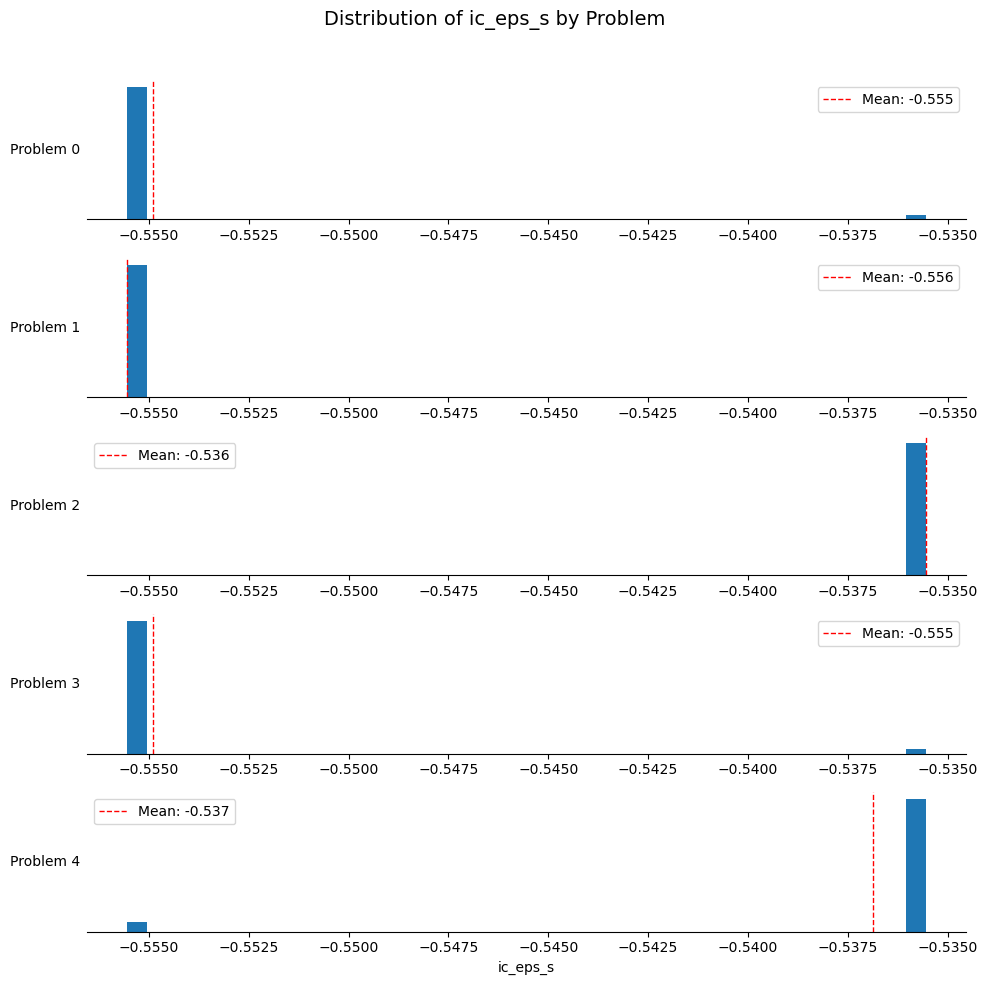

In [42]:
import sqlite3, numpy as np, pandas as pd
import matplotlib.pyplot as plt

def plot_feature():
    # Connect to the SQLite database
    con = sqlite3.connect("data/landscape-analysis.db")
    query = "SELECT * FROM loss_surfaces WHERE ic_h_max IS NOT NULL AND ic_h_max != 'pending'"
    df = pd.read_sql_query(query, con)
    con.close()
    
    # Choose the feature to visualize
    feature = 'ic_eps_s'

    # Get unique problems
    problems = sorted(df['problem_id'].unique())

    # Prepare plot
    fig, axes = plt.subplots(len(problems), 1, figsize=(10, len(problems) * 2), sharex=False)
    
    # Handle case when there's only one problem
    if len(problems) == 1:
        axes = [axes]
    
    # Plot histograms per problem
    for i, problem in enumerate(problems):
        problem_data = df[df['problem_id'] == problem]
        
        # Calculate bins specific to this problem's data
        min_val = df[feature].min()
        max_val = df[feature].max()
        bins = np.linspace(min_val, max_val, 40)
        
        ax = axes[i]
        ax.hist(problem_data[feature], bins=bins, orientation='vertical')
        ax.set_yticks([])  # Hide y-axis ticks for compactness
        ax.set_ylabel(f"Problem {problem}", rotation=0, labelpad=30, va='center')
        
        # Add statistics to help compare
        mean_val = problem_data[feature].mean()
        ax.axvline(mean_val, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_val:.3f}')
        
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.legend()

    # Aesthetics
    axes[-1].set_xlabel(feature)
    plt.suptitle(f"Distribution of {feature} by Problem", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
plot_feature()

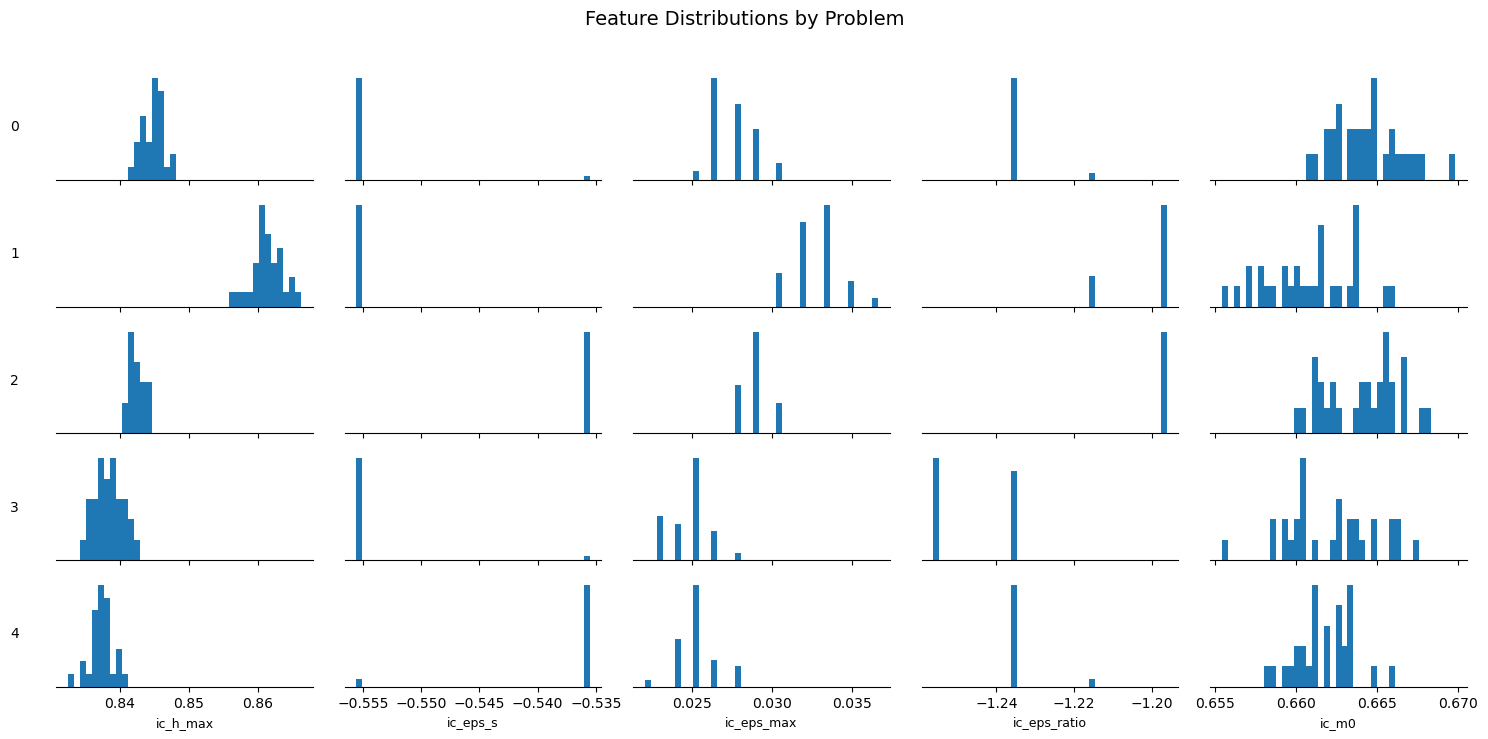

In [41]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_multiple_features():
    # Connect to the SQLite database
    con = sqlite3.connect("data/landscape-analysis.db")
    query = "SELECT * FROM loss_surfaces WHERE ic_h_max IS NOT NULL AND ic_h_max != 'pending'"
    df = pd.read_sql_query(query, con)
    con.close()
    
    # Define features to visualize
    features = ['ic_h_max', 'ic_eps_s', 'ic_eps_max', 'ic_eps_ratio', 'ic_m0']
    
    # Get unique problems
    problems = sorted(df['problem_id'].unique())

    # Create subplot grid
    fig, axes = plt.subplots(len(problems), len(features), 
                            figsize=(len(features) * 3, len(problems) * 1.5), 
                            sharex='col')
    
    # Handle case when there's only one problem
    if len(problems) == 1:
        axes = [axes]
        
    # Plot histograms for each problem and feature
    for i, problem in enumerate(problems):
        problem_data = df[df['problem_id'] == problem]
        for j, feature in enumerate(features):
            ax = axes[i][j]
            ax.hist(problem_data[feature].dropna(), 
                   bins=np.linspace(df[feature].min(), df[feature].max(), 40), 
                   orientation='vertical')
            ax.set_yticks([])  # Hide y-axis ticks
            
            # Set labels
            if j == 0:
                ax.set_ylabel(f"{problem}", rotation=0, labelpad=30, va='center')
            
            if i == len(problems) - 1:
                ax.set_xlabel(feature, fontsize=9)
                
            # Clean up appearance
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['left'].set_visible(False)

    # Add title and adjust layout
    plt.suptitle("Feature Distributions by Problem", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

plot_multiple_features()


Check the range of the parameter real quick

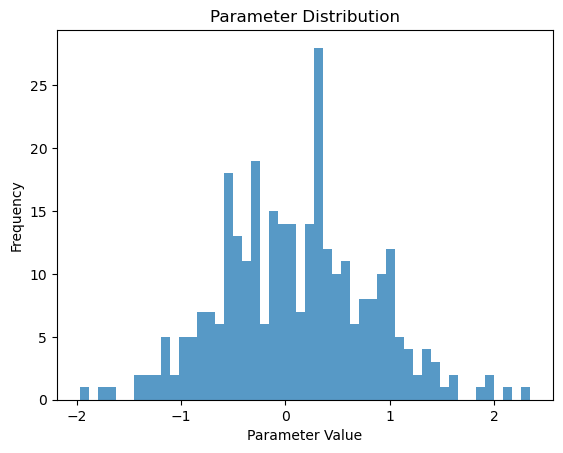

In [ ]:
import torch
from torch.nn.utils import parameters_to_vector
from matplotlib import pyplot as plt

def param_distribution():
    model = torch.load("fy601wtw-ed542e36.pth")
    vector = parameters_to_vector(model.values()).cpu().numpy()
    plt.hist(vector, bins=50, alpha=0.75)
    plt.title("Parameter Distribution")
    plt.xlabel("Parameter Value")
    plt.ylabel("Frequency")
    plt.show()
param_distribution() 